[sym_qsp] Iterative optimization to err 1.000e-12 or max_iter 100.
iter: 001 --- err: 7.696e-01
iter: 002 --- err: 4.460e-01
iter: 003 --- err: 3.741e-01
iter: 004 --- err: 2.142e-01
iter: 005 --- err: 3.849e-02
iter: 006 --- err: 5.122e-04
iter: 007 --- err: 5.338e-08
iter: 008 --- err: 4.168e-15
[sym_qsp] Stop criteria satisfied.


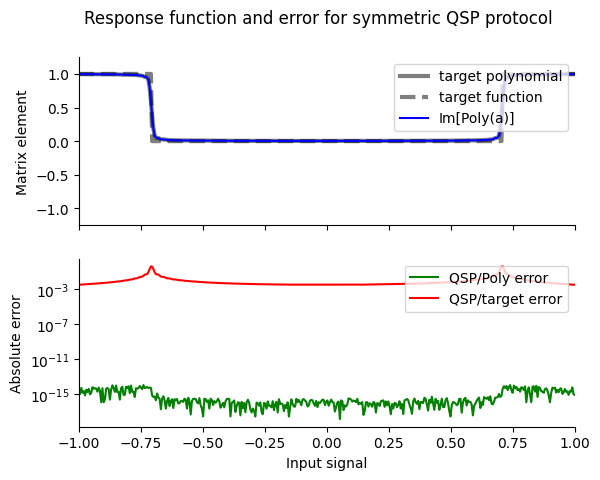

In [23]:
# Import relevant modules and methods.
import numpy as np
from numpy.polynomial import Chebyshev as T
# import pyqsp
from pyqsp import angle_sequence, response
from pyqsp.poly import (polynomial_generators, PolyTaylorSeries)
import matplotlib.pyplot as plt


alpha = np.pi

use_ansatz = True

# Target P(x) function.
target = lambda x: (1 + np.cos(alpha/2))/2 + (1 - np.cos(alpha/2))/2 * np.sign(2*x**2 - 1)

polydeg = 100
max_scale = 0.9

ansatz_coef = []

K = polydeg // 2

for k in range(K + 1):
    ansatz_coef.append(0.0) # idx 2k
    P_k = 4/np.pi * (1 - (2*k + 1)/(2*K + 2)) * \
        (-1)**k / (2*k + 1) # idx 2k+1
    ansatz_coef.append(P_k)

new_coef = []

for i, c in enumerate(ansatz_coef):
    new_coef.append(((1 + np.cos(alpha/2))/2 * c))
    new_coef.append(0.0)

new_coef[0] = (1 - np.cos(alpha/2))/2

ansatz_poly = T(new_coef)

if use_ansatz:
    poly = ansatz_poly
else:
    sign_func = PolyTaylorSeries().taylor_series(
        func=np.sign,
        degree=K,
        max_scale=max_scale,
        chebyshev_basis=True,
        cheb_samples=2*polydeg)
    
    poly_coef = []

    for c in sign_func.coef:
        poly_coef.append(((1 - np.cos(alpha/2))/2 * c))
        poly_coef.append(0.0)
    
    poly_coef[0] = (1 + np.cos(alpha/2))/2
    poly = T(poly_coef)

# Compute full phases (and reduced phases, parity) using symmetric QSP.
(phiset, red_phiset, parity) = angle_sequence.QuantumSignalProcessingPhases(
    poly,
    method='sym_qsp',
    chebyshev_basis=True)

"""
Plot response according to full phases.
Note that `pcoefs` are coefficients of the approximating polynomial,
while `target` is the true function (rescaled) being approximated.
"""
response.PlotQSPResponse(
    phiset,
    pcoefs=poly,
    target=target,
    sym_qsp=True,
    simul_error_plot=True,
    plot_real_only=False)


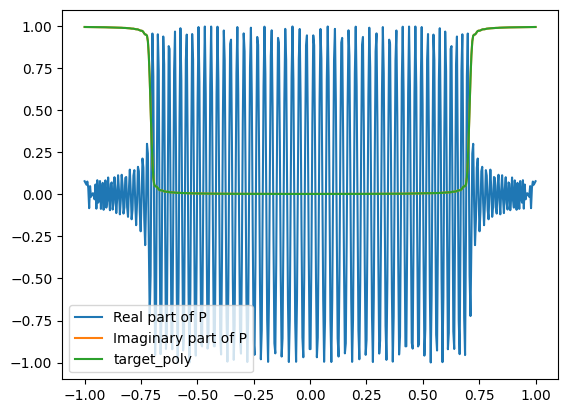

In [24]:
def sig_op(a): 
    return np.array(
            [[a, 1j * np.sqrt(1 - a**2)],
             [1j * np.sqrt(1 - a**2), a]])

def qsp_op(phi): 
    return np.array(
            [[np.exp(1j * phi), 0.],
             [0., np.exp(-1j * phi)]])


# Compute response
pmats = []
for phi in phiset:
    pmats.append(qsp_op(phi))

p_state = np.array([[1.], [0.]])


pdats_P = []
pdats_Q = []

for a in np.linspace(-1, 1, 500):
    W = sig_op(a)
    U = pmats[0]
    for pm in pmats[1:]:
        U = U @ W @ pm

    pdats_Q.append(U[1, 0])
    pdats_P.append(U[0, 0])


plt.plot(np.linspace(-1, 1, 500), np.real(pdats_P), label='Real part of P')
plt.plot(np.linspace(-1, 1, 500), np.imag(pdats_P), label='Imaginary part of P')
# plt.plot(np.linspace(-1, 1, 500), np.abs(pdats_P), label='Magnitude of P')
plt.plot(np.linspace(-1, 1, 500), poly(np.linspace(-1, 1, 500)), label='target_poly')

plt.legend()

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

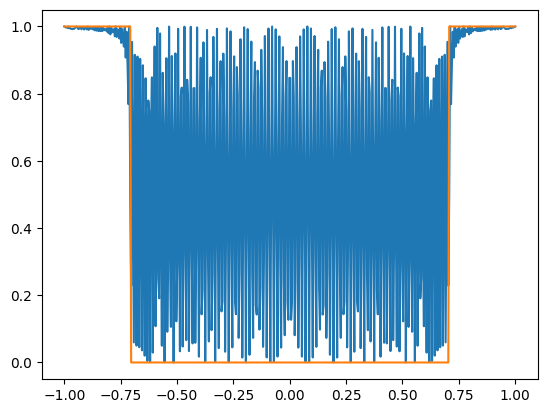

In [25]:
plt.plot(np.linspace(-1, 1, 500), np.abs(pdats_P)**2, label='Population of 0-state')
# plt.plot(np.linspace(-1, 1, 500), np.abs(pdats_Q)**2, label='Population of 1-state')
plt.plot(np.linspace(-1, 1, 500), target(np.linspace(-1, 1, 500))**2, label='target_population')
plt.legend

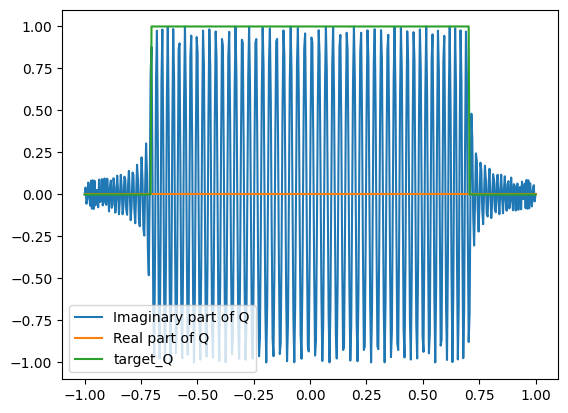

In [26]:
plt.plot(np.linspace(-1, 1, 500), np.imag(pdats_Q), label='Imaginary part of Q')
plt.plot(np.linspace(-1, 1, 500), np.real(pdats_Q), label='Real part of Q')

target_Q = lambda x: np.sqrt(1 - target(x)**2)


plt.plot(np.linspace(-1, 1, 500), target_Q(np.linspace(-1, 1, 500)), label='target_Q')


plt.legend()

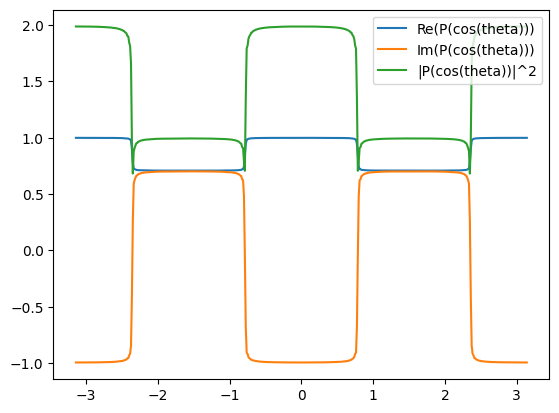

In [34]:
alpha = np.pi/2

ansatz_coef = []

K = 50

for k in range(K + 1):
    ansatz_coef.append(0.0) # idx 2k
    P_k = 4/np.pi * (1 - (2*k + 1)/(2*K + 2)) * \
        (-1)**k / (2*k + 1) # idx 2k+1
    ansatz_coef.append(P_k)

new_coef = []

for i, c in enumerate(ansatz_coef):
    # new_coef.append(((1 - np.cos(alpha/2))/2 * c))
    new_coef.append(((1  - 1j - np.exp(1j*alpha/2))/2 * c))
    new_coef.append(0.0)

new_coef[0] = (1 - 1j + np.exp(1j*alpha/2))/2

P_func = T(new_coef)

theta = np.linspace(-np.pi, np.pi, 500)
x = np.cos(theta)

plt.plot(theta, P_func(x).real, label='Re(P(cos(theta)))')
plt.plot(theta, P_func(x).imag, label='Im(P(cos(theta)))')
plt.plot(theta, P_func(x).real ** 2 + P_func(x).imag ** 2, label='|P(cos(theta))|^2')
plt.legend()